# 2. Extract Raster Values at Point Locations 

Use the rasterstats.zonal_stats() function to extract raster pixel values using a vector extent or set of extents.

On this page, you will extract pixel values that cover each field plot area where trees were measured in the NEON Field Sites. The idea is that you can **calculate the mean or max height value for all pixels** that fall in each NEON site.

To do this, you need to do the following:

- Import the canopy height model that you wish to extra tree height data from.
- Clean up that data. For instance if there are values of 0 for areas where there are no trees they will impact a mean value calculation. It is better to remove those values from the data.
- Finally you will import and create a buffer zone that represents the area where trees were sampled in each NEON field site.

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import geopandas as gpd
# Rasterstats contains the zonalstatistics function
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set working directory
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

## Import Canopy Height Model
First, you will import a canopy height model created by the National Ecological Observatory Network (NEON). In the previous lessons / weeks you learned how to make a canopy height model by subtracting the Digital elevation model (DEM) from the Digital surface model (DSM).

In [6]:
# Load & plot the data
sjer_lidar_chm_path = os.path.join("spatial-vector-lidar",
                                   "california", 
                                   "neon-sjer-site",
                                   "2013", 
                                   "lidar", 
                                   "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(sjer_lidar_chm_path, masked=True).squeeze()

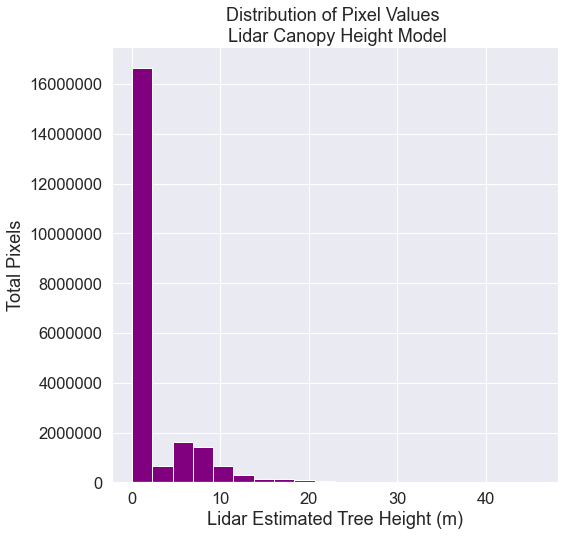

In [11]:
# Explore the data by plotting a histogram with earthpy
ax = ep.hist(sjer_chm_data.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Lidar Estimated Tree Height (m)",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

In [12]:
# EXPLORE: View summary statistics of canopy height model
# Notice the mean value with 0's included in the data
print('Mean:', sjer_chm_data.mean().values)
print('Max:', sjer_chm_data.max().values)
print('Min:', sjer_chm_data.min().values)

Mean: 1.9355862
Max: 45.879997
Min: 0.0


## Clean Up Data - Remove 0’s
Looking at the distribution of data, you can see there are many pixels that have a value of 0 - where there are no trees. Also, using the NEON data, values below 2m are normally set to 0 given the accuracy of the lidar instrument used to collect these data.m

Set all pixel values ==0 to nan as they will impact calculation of plot mean height. You can do this with the .where argument that is available on all xarray objects. Set a condition, and the .where function will replace all values that DON’T meet that condition with the value provided. For example, xarray_object = xarray_object.where(xarray_object == 1, 2) will replace all values that ARE NOT equal to one with a two. A mean calculated with values of 0 will be significantly lower than a mean calculated with just tree height values.

In [15]:
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
sjer_chm_data_no_zeros = sjer_chm_data.where(sjer_chm_data != 0, np.nan)
# View summary statistics of canopy height model after cleaning up the data
print('Mean:', sjer_chm_data_no_zeros.mean().values)
print('Max:', sjer_chm_data_no_zeros.max().values)
print('Min:', sjer_chm_data_no_zeros.min().values)

Mean: 8.213505
Max: 45.879997
Min: 2.0


Look at the histogram of the data with the 0’s removed. Now you can see the true distribution of heights in the data without the 0’s.

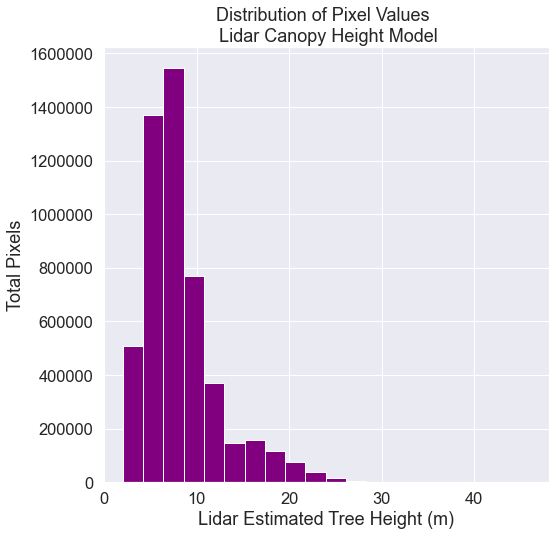

In [16]:
# Explore the data by plotting a histogram with earthpy
ax = ep.hist(sjer_chm_data_no_zeros.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Lidar Estimated Tree Height (m)",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

## Import Plot Location Data & Create Buffer
You now have a cleaned canopy height model for your study area in California. However, how do the height values extracted from the CHM compare to our manually collected, field measured canopy height data? To figure this out, you will use in situ collected tree height data, measured within circular plots across our study area. You will compare the maximum measured tree height value to the maximum LiDAR derived height value for each circular plot using regression.

First, import the shapefile that contains the plot centroid (the center point of each plot) locations using geopandas.

In [17]:
sjer_centroids_path = os.path.join("spatial-vector-lidar",
                                   "california", 
                                   "neon-sjer-site",
                                   "vector_data", 
                                   "SJER_plot_centroids.shp")

sjer_plots_points = gpd.read_file(sjer_centroids_path)

type(sjer_plots_points)

geopandas.geodataframe.GeoDataFrame

In [22]:
# Ensure this is a points layer as you think it is
sjer_plots_points.geom_type

0     Point
1     Point
2     Point
3     Point
4     Point
5     Point
6     Point
7     Point
8     Point
9     Point
10    Point
11    Point
12    Point
13    Point
14    Point
15    Point
16    Point
17    Point
dtype: object

### Overlay Points on Top Of Your Raster Data
Finally, a quick plot allows you to check that your points actually overlay on top of the canopy height model. This is a good sanity check just to ensure your data actually line up and are for the same location.

We have previously discussed the spatial extent of a raster. Here is where you will need to set the spatial extent when plotting raster using ep.plot_bands. If you do not specify a spatial extent, your raster will not line up properly with your geopandas object.

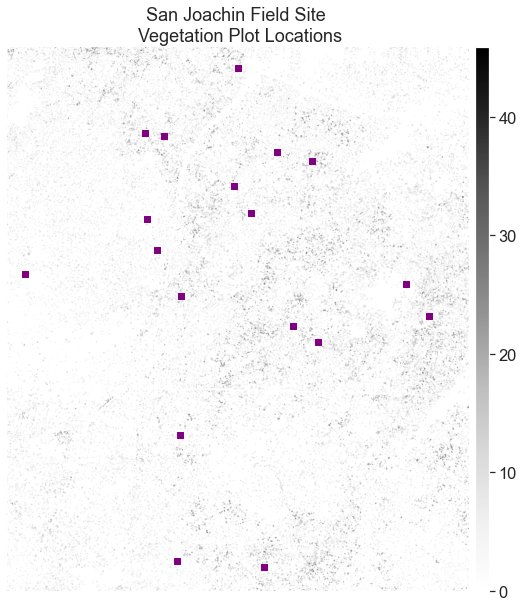

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

# We plot with the zeros in the data so the CHM can be better represented visually
ep.plot_bands(sjer_chm_data,
              extent=plotting_extent(sjer_chm_data,
                                     sjer_chm_data.rio.transform()),  # Set spatial extent
              cmap='Greys',
              title="San Joachin Field Site \n Vegetation Plot Locations",
              scale=False,
              ax=ax)

sjer_plots_points.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='purple')
ax.set_axis_off()
plt.show()

## Create A Buffer Around Each Plot Point Location
Each point in your data represent the center location of a plot where trees were measured. You want to extract tree height values derived from the lidar data for the entire plot. To do this, you will need to create a BUFFER around the points representing the region of the plot where data were collected.

In this case, your plot size is 40m. If you create a circular buffer with a 20m diameter, it will closely approximate where trees were measured on the ground.

You can use the .buffer() method to create the buffer. Here the buffer size is specified in the () of the function. You will send the new object to a new shapefile using .to_file() as follows:

#### SJER_plots.buffer(20).to_file('path-to-shapefile-here.shp')

Below you:

- Make a copy of the points layer that will become a new polygon layer.
- Buffer the points layer using the .buffer() method. This will produce a circle around each point that is x units radius. The units will coincide with the CRS of your data. This is known as a buffer.
- When you perform the buffer, you UPDATE the “geometry” column of your new poly layer with the buffer output.

In [21]:
# Create a buffered polygon layer from your plot location points
sjer_plots_poly = sjer_plots_points.copy()

# Buffer each point using a 20 meter circle radius
# and replace the point geometry with the new buffered geometry
sjer_plots_poly["geometry"] = sjer_plots_points.geometry.buffer(20)
sjer_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


Finally, export the buffered layer as a new shapefile. 

In [23]:
# If the dir does not exist, create it
output_path = os.path.join("spatial-vector-lidar", 
                           "outputs")

if not os.path.isdir(output_path):
    os.mkdir(output_path)

# Export the buffered point layer as a shapefile to use in zonal stats
plot_buffer_path = os.path.join(output_path, 
                                "plot_buffer.shp")

sjer_plots_poly.to_file(plot_buffer_path)

##Extract Pixel Values For Each Plot
Once you have the boundary for each plot location (a 20m diameter circle) you can extract all of the pixels that fall within each circle using the function zonal_stats in the rasterstats library.

There are several ways to use the zonal_stats function. In this case we are providing the following

- chm data (numpy array): **sjer_chm_data_no_zeros** in a numpy array format (you can turn an xarray object into a numpy array by adding **.values** after the object name, for example, sjer_chm_data_no_zeros is an xarray object, and sjer_chm_data_no_zeros.values is the numpy version of the same data.
- Because a numpy array has no spatial information, you provide the affine data which is the spatial information needed to spatially located the array.
- plot_buffer_path: this is the path to the buffered point shapefile that you created at the top of this lesson

In [26]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data_no_zeros.values,
                                   nodata=-999,
                                   affine=sjer_chm_data_no_zeros.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# View object type
type(sjer_tree_heights)

list

Convert the list output to a geodataframe that you can plot the data.

In [27]:
sjer_tree_heights

[{'type': 'Feature',
  'id': '0',
  'properties': OrderedDict([('Plot_ID', 'SJER1068'),
               ('Point', 'center'),
               ('northing', 4111567.818),
               ('easting', 255852.376),
               ('plot_type', 'trees'),
               ('min', 2.0399999618530273),
               ('max', 19.049999237060547),
               ('mean', 11.544347580915652),
               ('count', 161),
               ('median', 12.619999885559082)]),
  'geometry': {'type': 'Polygon',
   'coordinates': [[(255872.376, 4111567.818),
     (255872.27969453344, 4111565.857657193),
     (255871.99170560806, 4111563.9161935598),
     (255871.51480671464, 4111562.012306455),
     (255870.85359065022, 4111560.164331353),
     (255870.01442528696, 4111558.3900652635),
     (255869.00539224604, 4111556.7065953393),
     (255867.83620906723, 4111555.1301343166),
     (255866.51813562372, 4111553.675864376),
     (255865.06386568327, 4111552.3577909325),
     (255863.48740466038, 4111551.18860775

In [28]:
# Turn extracted data into a pandas geodataframe
sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,min,max,mean,count,median
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,2.04,19.049999,11.544348,161,12.62
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,2.10,24.019999,10.369277,443,7.87
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,2.82,16.070000,7.518398,643,6.80
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,3.24,11.059999,7.675347,245,7.93
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,3.38,5.740000,4.591176,17,4.45


Below is a bar plot of max lidar derived tree height by plot id. This plot allows you to see how vegetation height varies across the field sites.

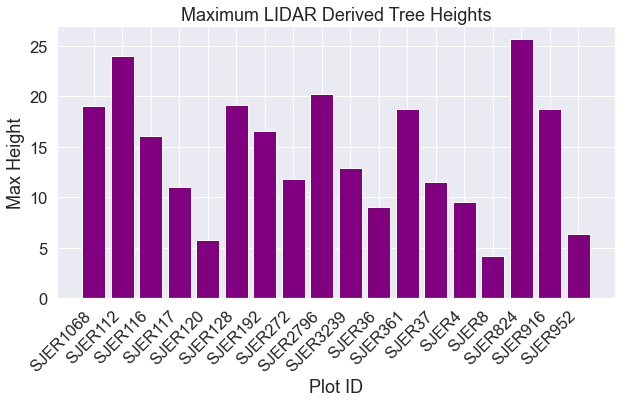

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(sjer_lidar_height_df['Plot_ID'],
       sjer_lidar_height_df['max'],
       color="purple")

ax.set(xlabel='Plot ID', 
       ylabel='Max Height',
       title='Maximum LIDAR Derived Tree Heights')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

If you want to explore the data distribution of pixel height values in each plot, rasterstats includes the datapoints corresponding to each zone. To access this, we included the raster_out keyword argument when we calculated the raster stats.

The raster_out argument creates a small raster with just the pixel values for each individual plot. You can then plot a histogram of each plot to assess the distribution of data values. This step is helpful if you need to further explore your data to identify potential issues or to better understand what is going on in the data.

Below you loop through the points included in each zone and show a histogram of its values. Note that each set of points is stored as a masked array. This is because images must be shaped as squares, while our zone may be any shape that we wish. The mask tells us which pixels fall into the zone.

In [38]:
# Extract zonal stats but retain the individual pixel values into a list
sjer_tree_heights_ras = rs.zonal_stats(plot_buffer_path,
                                       sjer_chm_data_no_zeros.values,
                                       nodata=-999,
                                       affine=sjer_chm_data_no_zeros.rio.transform(),
                                       geojson_out=True,
                                       raster_out=True,
                                       copy_properties=True,
                                       stats="count min mean max median")
# Convert to geodataframe
sjer_lidar_height_df_ras = gpd.GeoDataFrame.from_features(
    sjer_tree_heights_ras)

# View subset of the dataframe
sjer_lidar_height_df_ras[["Plot_ID", 
                          "count", 
                          "geometry",
                          "mini_raster_affine", 
                          "mini_raster_array"]].head()

,Plot_ID,count,geometry,mini_raster_affine,mini_raster_array
0,SJER1068,161,"POLYGON ((255872.376 4111567.818, 255872.280 4...","(1.0, 0.0, 255832.0, 0.0, -1.0, 4111588.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
1,SJER112,443,"POLYGON ((257426.967 4111298.971, 257426.871 4...","(1.0, 0.0, 257386.0, 0.0, -1.0, 4111319.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
2,SJER116,643,"POLYGON ((256858.760 4110819.876, 256858.664 4...","(1.0, 0.0, 256818.0, 0.0, -1.0, 4110840.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
3,SJER117,245,"POLYGON ((256196.947 4108752.026, 256196.851 4...","(1.0, 0.0, 256156.0, 0.0, -1.0, 4108773.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
4,SJER120,17,"POLYGON ((255988.372 4110476.079, 255988.276 4...","(1.0, 0.0, 255948.0, 0.0, -1.0, 4110497.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."


Below you create a plot for each individual field site of all pixel values using earthpy.

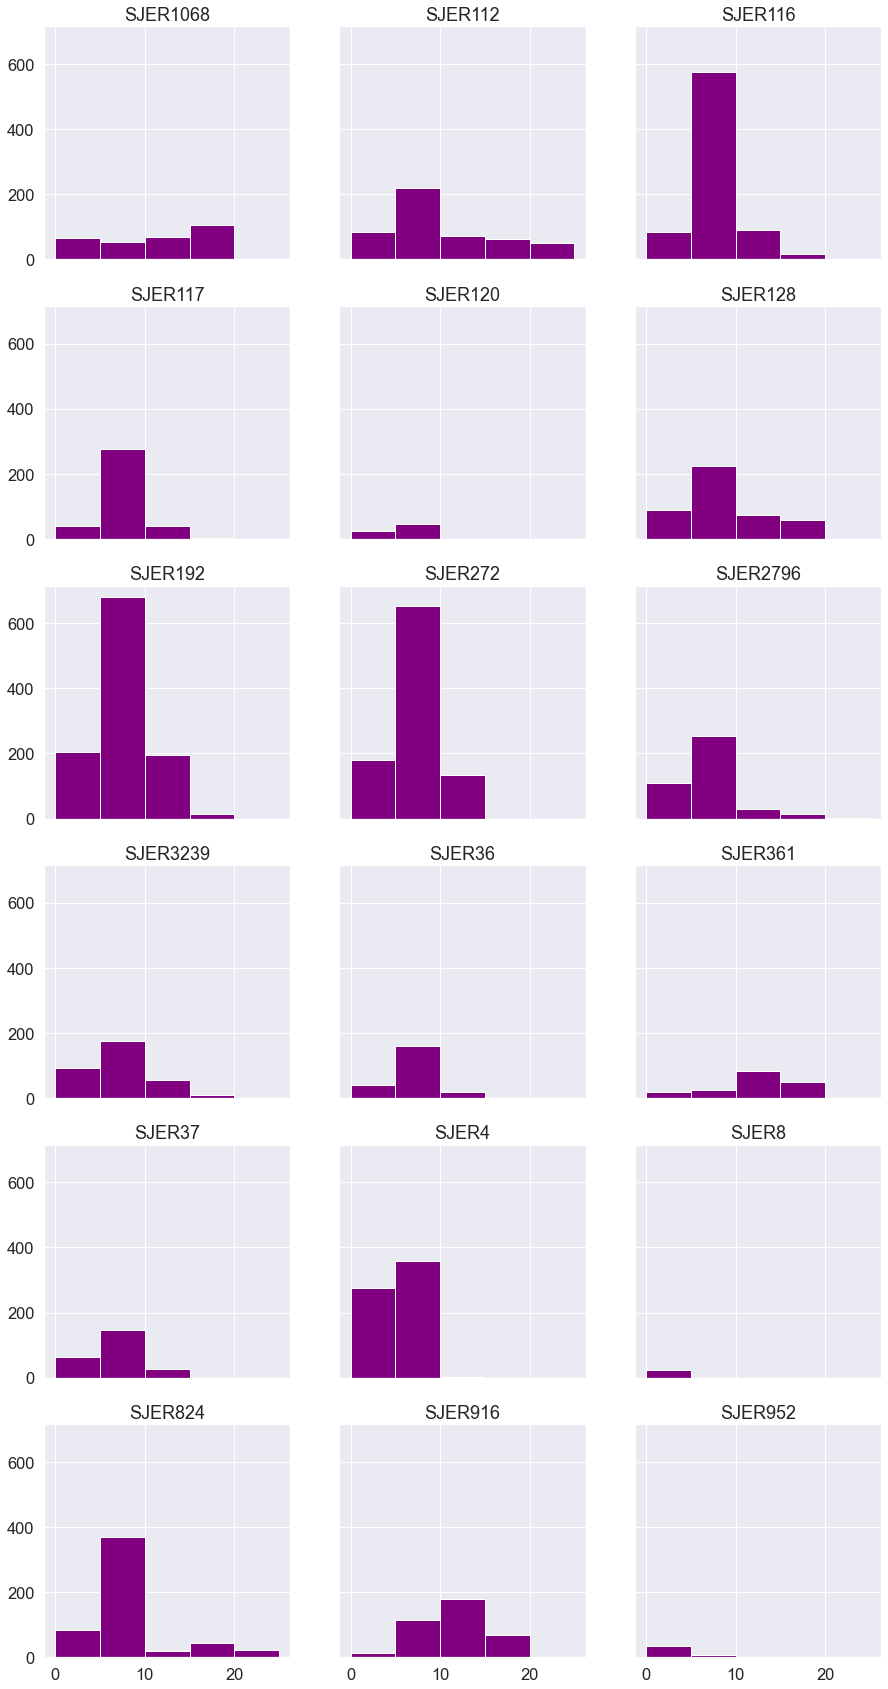

In [32]:
# Get list of sites
site_names = list(sjer_lidar_height_df_ras["Plot_ID"])

# Convert data in dataframe to a numpy array
arr = np.stack(sjer_lidar_height_df_ras['mini_raster_array'])

# Plot using earthpy
ep.hist(arr,
        bins=[0, 5, 10, 15, 20, 25],
        cols=3,
        title=site_names, 
        figsize=(15, 30))

plt.show()